In [1]:
# from https://towardsdatascience.com/multi-class-text-classification-with-scikit-learn-12f1e60e0a9f

import pandas as pd
import sklearn as sk
import numpy as np

In [2]:
df = pd.read_csv('./sns.csv')

In [3]:
df.head()

,Item,Category,Subcategory
0,nabisco instant cream of wheat hot cereal 12 c...,breakfast-cereal,breakfast-cereal
1,swiffer wet mopping cloths febreze lavender 24...,laundry-paper-cleaning,household-cleaners
2,hartz duraplay medium dog toy bone bacon scent...,pet-store,dog-treats-toys
3,stouffers classics macaroni beef 127 oz box,frozen,frozen-meals-entrees-sides
4,lean cuisine favorites lasagna with meat sauce...,frozen,frozen-meals-entrees-sides


In [4]:
# create mappings etween category and category id
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)
df.head(200)

,Item,Category,Subcategory,category_id
0,nabisco instant cream of wheat hot cereal 12 c...,breakfast-cereal,breakfast-cereal,0
1,swiffer wet mopping cloths febreze lavender 24...,laundry-paper-cleaning,household-cleaners,1
2,hartz duraplay medium dog toy bone bacon scent...,pet-store,dog-treats-toys,2
3,stouffers classics macaroni beef 127 oz box,frozen,frozen-meals-entrees-sides,3
4,lean cuisine favorites lasagna with meat sauce...,frozen,frozen-meals-entrees-sides,3
...,...,...,...,...
195,maplehurst pie lemon meringue 8 inch 225 oz pkg,bread-bakery,bakery-pies-desserts,6
196,mjays specialty gourmet brownie platter smores...,bread-bakery,bakery-pies-desserts,6
197,table talk old fashioned baked cherry pie 4 oz...,bread-bakery,bakery-pies-desserts,6
198,stop shop bakery limited time holiday spice lo...,bread-bakery,bakery-pies-desserts,6


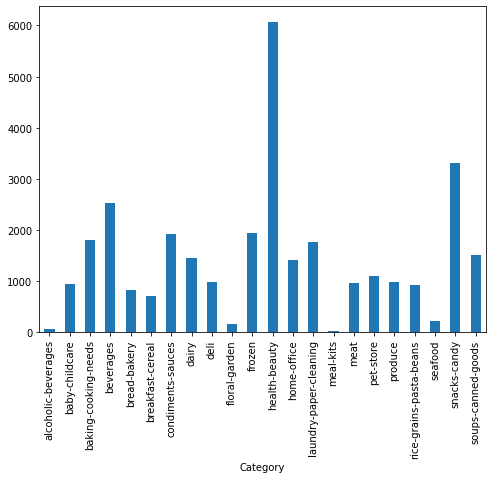

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Category').Item.count().plot.bar(ylim=0)
plt.show()

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 6), stop_words='english')
features = tfidf.fit_transform(df.Item).toarray()
labels = df.category_id
features.shape

(31668, 22931)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Item'], df['Category'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [8]:
print(clf.predict(count_vect.transform(["oatmeal"])))

['breakfast-cereal']


In [9]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2


cat = "snacks-candy"
category_id = category_to_id[cat]

features_chi2 = chi2(features, labels == category_id)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names())[indices]

print("# '{}':".format(cat))
for idx in range(1,7):
    ngrams = [v for v in feature_names if len(v.split(' ')) == idx]
    
    print(f"   . Most correlated {idx}-grams\n")
    print('\n'.join(ngrams[-N:]))


# 'snacks-candy':
   . Most correlated 1-grams

crackers
chips
   . Most correlated 2-grams

potato chips
oz bag
   . Most correlated 3-grams

lays potato chips
baked snack crackers
   . Most correlated 4-grams

gluten free oz bag
kettle cooked potato chips
   . Most correlated 5-grams

cod kettle cooked potato chips
cape cod kettle cooked potato
   . Most correlated 6-grams

pepperidge farm goldfish baked snack crackers
cape cod kettle cooked potato chips


In [13]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
# from sklearn.model_selection import cross_val_score
# models = [
#     RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
#     LinearSVC(),
#     MultinomialNB(),
# #     LogisticRegression(random_state=0),
# ]
# CV = 5
# cv_df = pd.DataFrame(index=range(CV * len(models)))
# entries = []
# for model in models:
#   model_name = model.__class__.__name__
#   accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
#   for fold_idx, accuracy in enumerate(accuracies):
#     entries.append((model_name, fold_idx, accuracy))
# cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [15]:
import seaborn as sns
# sns.boxplot(x='model_name', y='accuracy', data=cv_df)
# sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
#               size=8, jitter=True, edgecolor="gray", linewidth=2)
# plt.show()

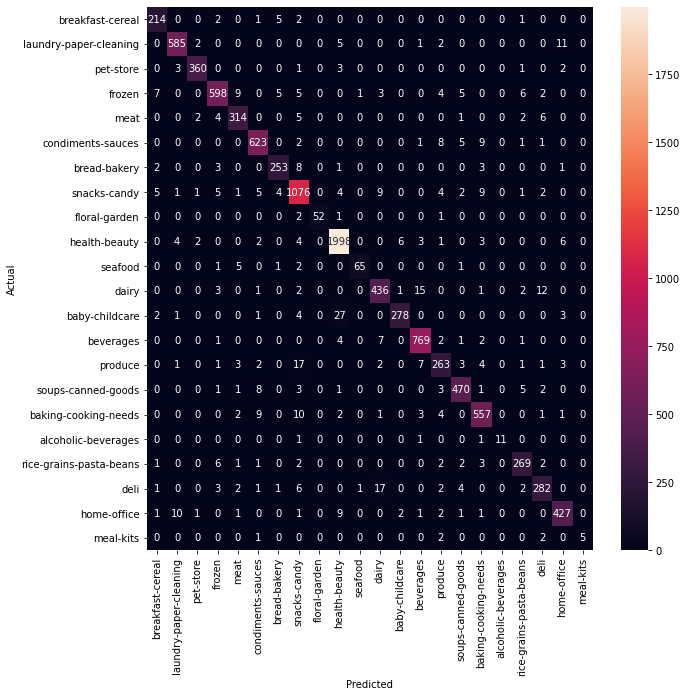

In [16]:
# LinearSVC seems to perform best
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Category.values, yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [17]:
# export the model as a pickle file
import pickle

with open('categorize-model.pickle', 'wb') as handle:
    pickle.dump(model, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
from IPython.display import display
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['Category', 'Item']])
      print('')

'home-office' predicted as 'laundry-paper-cleaning' : 10 examples.


,Category,Item
24193,home-office,zak insulated bottle lilac 20 oz 1 ea
24199,home-office,stop shop fitness blender bottle 28 oz 1 ea
24194,home-office,zak insulated bottle indigo 19 oz 1 ea
23820,home-office,armor all auto cleaner multi purpose trigger s...
23804,home-office,prestone interior cleaner odor neutralizer 18 ...
24004,home-office,papercraft tissue paper white 20 x 20 inch 25 ...
20992,home-office,febreze candle gain scent 2 ct 62 oz pkg
24189,home-office,rubbermaid stain odor resistant leak proof bot...
23853,home-office,true grip suede leather palm gloves large 2 gl...
23851,home-office,true grip jersey gloves brown large 1 pair 2 g...



'produce' predicted as 'snacks-candy' : 17 examples.


,Category,Item
26379,produce,manischewitz mixed fruit 8 oz bag
26958,produce,stop shop banana chips dried 55 oz tub
26985,produce,stop shop pistachios roasted unsalted 675 oz tub
27016,produce,natures promise monster trail mix 12 oz bag
26980,produce,bare baked crunchy coconut chips chocolate 28 ...
26910,produce,dang coconut chips caramel sea salt toasted 31...
26978,produce,great lakes fancy apricots sun dried 12 oz tub
10573,produce,stop shop fresh vegetable platter with ranch v...
9918,produce,stop shop fresh fruit platter with cream chees...
7811,produce,mccormick bac n pieces chips 41 oz jar



'baking-cooking-needs' predicted as 'snacks-candy' : 10 examples.


,Category,Item
1500,baking-cooking-needs,carnation almond cooking milk dairy free organ...
2912,baking-cooking-needs,godiva pudding mix white chocolate vanilla bea...
1876,baking-cooking-needs,yehuda matzos matzo farfel kosher for passover...
1249,baking-cooking-needs,russell stover baking chips sugar free dark ch...
1845,baking-cooking-needs,sclafani durum wheat semolina 176 oz pkg
2011,baking-cooking-needs,colmans mustard powder double superfine 2 oz tin
2802,baking-cooking-needs,blue dragon sushi nori roasted seaweed sheets ...
1227,baking-cooking-needs,alprose swiss baking chocolate bitter sweet pa...
2904,baking-cooking-needs,gefen jell dessert strawberry kosher for passo...
2791,baking-cooking-needs,manitoba harvest hemp hearts shelled hemp seed...



'baby-childcare' predicted as 'health-beauty' : 27 examples.


,Category,Item
19751,baby-childcare,flonase childrens sensimist allergy relief 60 ...
20624,baby-childcare,cantu care for kids nourishing conditioner 8 o...
16720,baby-childcare,aunt jackies knot on my watch instant detangli...
17529,baby-childcare,careone ibuprofen junior strength 100 mg table...
15665,baby-childcare,johnsons baby bath moisture care 15 oz btl
17516,baby-childcare,advil junior strength ibuprofen 100 mg grape f...
17525,baby-childcare,baby orajel non medicated cooling gels for tee...
17523,baby-childcare,wellements organic baby tooth oil 4 months 05 ...
18084,baby-childcare,mustela hydra bebe body lotion 1014 oz btl
15685,baby-childcare,disney frozen 3 in 1 body wash shampoo conditi...



'deli' predicted as 'dairy' : 17 examples.


,Category,Item
10746,deli,kerrygold dubliner cheese wedges grass fed 5 o...
10758,deli,goya nela queso de papa 10 oz pkg
10726,deli,stop shop parmesan cheese shredded 12 lb bag
10843,deli,sargento balanced breaks pepper jack colby jac...
10731,deli,auricchio sunday blend premium parmesan pecori...
10664,deli,cabot cheddar cheese with garlic herb 8 oz bar
10769,deli,tillamook habanero jack cheese spicy 7 oz pkg
10762,deli,fromager d affinois triple cream cheese 65 oz pkg
10663,deli,cabot hand select premium cheddar cheese extra...
10592,deli,naturally good kosher brie cheese double cream...



'dairy' predicted as 'beverages' : 15 examples.


,Category,Item
5820,dairy,horizon organic low fat strawberry milk 6 pk 8...
5987,dairy,live real farms dairy oat milk blend original ...
5814,dairy,natures promise organic 1 low fat milk 1 gallon
3939,dairy,tropicana essentials probiotics juice peach pa...
5982,dairy,pacific foods vanilla oat beverage plant based...
5904,dairy,horizon organic growing years whole milk 12 ga...
9846,dairy,snapple mango tea 64 oz btl
9852,dairy,pure leaf real brewed lemon tea all natural 59...
5278,dairy,pure leaf real lemon brewed tea 185 oz btl
6002,dairy,living harvest tempt hemp milk original 1 quart



'dairy' predicted as 'deli' : 12 examples.


,Category,Item
5949,dairy,meyenberg goat milk 1 quart
8946,dairy,red apple cheese apple smoked all natural goud...
9090,dairy,supreme soft ripened supremely creamy cheese b...
8909,dairy,belgioioso salad blend asiago parmesan romano ...
8942,dairy,mini babybel cheese original semisoft 6 ct 45 ...
8954,dairy,land o lakes deli american cheese product yell...
9219,dairy,the laughing cow spreadable cheese wedges crea...
8966,dairy,boars head american cheese yellow pre sliced 8...
8905,dairy,belgioioso mascarpone cheese 16 oz tub
9255,dairy,stop shop deli imported swiss cheese thin slic...



'laundry-paper-cleaning' predicted as 'home-office' : 11 examples.


,Category,Item
21207,laundry-paper-cleaning,lami mini butler set broom dustpan 1 ct pkg
22462,laundry-paper-cleaning,good cook party frills 72 ct pkg
22345,laundry-paper-cleaning,good living sippie bowl for kids 2 ct 2 ct pkg
21362,laundry-paper-cleaning,rubbermaid pitcher with ice guard 1 gallon 1 ea
21755,laundry-paper-cleaning,febreze dirt devil u vacuum filters 3 ct box
20946,laundry-paper-cleaning,yankee candle cozy corner wax melts american h...
21508,laundry-paper-cleaning,brite concepts onion pod 1 ea pkg
20938,laundry-paper-cleaning,yankee candle wax melt fragranced home inspira...
21097,laundry-paper-cleaning,evercare pet hair roller giant 60 sheets 1 ct pkg
22057,laundry-paper-cleaning,items 4 u spray bottle 6 oz 2 ct 1 ea


In [19]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, target_names=df['Category'].unique()))

                         precision    recall  f1-score   support

       breakfast-cereal       0.92      0.95      0.93       225
 laundry-paper-cleaning       0.97      0.97      0.97       606
              pet-store       0.98      0.97      0.98       370
                 frozen       0.95      0.93      0.94       645
                   meat       0.93      0.94      0.93       334
      condiments-sauces       0.95      0.96      0.95       650
           bread-bakery       0.94      0.93      0.94       271
           snacks-candy       0.93      0.95      0.94      1129
          floral-garden       1.00      0.93      0.96        56
          health-beauty       0.97      0.98      0.98      2029
                seafood       0.97      0.87      0.92        75
                  dairy       0.92      0.92      0.92       473
         baby-childcare       0.97      0.88      0.92       316
              beverages       0.96      0.98      0.97       787
                produce 

In [20]:
svc = model.fit(features, labels)

In [25]:
# save the tfidf, id to category map, and the model itself
import joblib

joblib.dump(tfidf, "tfidf.pkl")
joblib.dump(id_to_category, "id_to_category.pkl")
joblib.dump(model, "model.pkl")



['model.pkl']

In [24]:


items = [
    "fresca",
    "oatmeal",
    "alpo dog beef dinner",
]
item_features = tfidf.transform(items)

predictions = model.predict(item_features)

for item, predicted in zip(items, predictions):
  print('"{}"'.format(item))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")


"fresca"
  - Predicted as: 'beverages'

"oatmeal"
  - Predicted as: 'breakfast-cereal'

"alpo dog beef dinner"
  - Predicted as: 'pet-store'



In [ ]:
cv_df.groupby('model_name').accuracy.mean()


In [ ]:
from sklearn import joblib

# Save to file in the current working directory
joblib_file = "joblib_model.pkl"
joblib.dump(model, joblib_file)